In [60]:
import random
import torch.nn as nn
import torch
import time
import math
import pickle
import pandas as pd
from pandas import Series, DataFrame
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
import sys
import json
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score
import random
import pickle
from rdkit.Chem import rdchem, Lipinski
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromFASTA, MolToSmiles, MolFromSmiles
from sklearn.model_selection import GridSearchCV
import numpy as np
import torch.optim as optim
folder = "/data/AIpep-clean/"
import matplotlib.pyplot as plt
from Levenshtein import distance as lev_dist
from models import Classifier
import tmap as tm
from map4 import MAP4Calculator

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Plot properties

In [400]:
df_all_nohem = pd.read_pickle(folder +"/pickles/all_sequences_with_NN_prop_helicity.pkl")
df_all = pd.read_pickle(folder +"/pickles/all_sequences_with_NN_prop_helicity-hem.pkl")

In [391]:
df_all.columns

Index(['ID', 'Name', 'N terminus', 'Sequence', 'C terminus', 'targetSpecies',
       'baumannii', 'aureus', 'aeruginosa', 'activity', 'Set', 'prediction',
       'Repetition', 'inTraining', 'isPredActive', 'dist_Training',
       'NN_Training', 'dist_Test', 'NN_Test', 'SMILES', 'MAP4',
       'map_dist_Training', 'map_NN_Training', 'map_dist_Test', 'map_NN_Test',
       'length', 'D_AA', 'A_fract', 'C_fract', 'D_fract', 'E_fract', 'F_fract',
       'G_fract', 'H_fract', 'I_fract', 'L_fract', 'M_fract', 'N_fract',
       'P_fract', 'K_fract', 'Q_fract', 'R_fract', 'S_fract', 'T_fract',
       'V_fract', 'W_fract', 'Y_fract', 'positive', 'negative', 'HAC', 'HBA',
       'HBD', 'hydrophobic', 'hydrophobic_patches', 'hydrophobic_patches_num',
       'hydrophobic_patches_len', 'hydro_res_fract', 'pos_res_fract',
       'HydroMoment', 'charge', 'hydrophobicity', 'av_hydrophobicity',
       'discrimination', 'fasta', 'SpiderFilename', 'SpiderFileloc', 'SS',
       'countH', 'fraction_PredHeli

In [404]:
training_test_hem = df_all.query("Set=='training' or Set=='test'").copy()
training_test_act = df_all_nohem.query("Set=='training' or Set=='test'").copy()

In [406]:
training_test = pd.concat([training_test_act, training_test_hem])

In [407]:
len(training_test)

11802

In [408]:
n_embedding = 100
n_hidden = 400
n_layers = 1
epoch = 95

filename = folder + "models/RNN-classifier-hem/em{}_hi{}_la{}_ep{}".format(n_embedding, n_hidden, n_layers, epoch)

model_hemolysis = Classifier.load_from_file(filename)

if torch.cuda.is_available():
    device = "cuda" 
else:
    device = "cpu" 

model_hemolysis.to(device)

ClassifierRNN(
  (embedding): Embedding(42, 100)
  (rnn): GRU(100, 400, batch_first=True)
  (output_layer): Linear(in_features=400, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

In [409]:
n_embedding = 100
n_hidden = 400
n_layers = 2
epoch = 38

filename = folder + "models/RNN-classifier/em{}_hi{}_la{}_ep{}".format(n_embedding, n_hidden, n_layers, epoch)

model_activity = Classifier.load_from_file(filename)

if torch.cuda.is_available():
    device = "cuda" 
else:
    device = "cpu" 

model_activity.to(device)

ClassifierRNN(
  (embedding): Embedding(42, 100)
  (rnn): GRU(100, 400, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=400, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

In [410]:
training_test["prediction"] = training_test.Sequence.map(lambda x: model_activity.predict_peptide_sequence(x)[:,1][0])
training_test["isPredActive"] = training_test["prediction"] > 0.99205756
training_test["prediction_hem"] = training_test.Sequence.map(lambda x: model_hemolysis.predict_peptide_sequence(x)[:,1][0])
training_test["isPredNotHemolytic"] = training_test["prediction_hem"] > 0.99981695

In [413]:
len(training_test.query("(Set=='training' or Set=='test') and activity == 1 and (isNotHemolytic == 1 or isPredNotHemolytic==1)"))#" and length <= 15"))

1829

In [417]:
len(training_test.query("isNotHemolytic == 0"))

1319

In [430]:
len(training_test.query("(Set=='training' or Set=='test') and activity == 1 and isNotHemolytic == 1 and length <= 15").Sequence.unique())

396

In [429]:
len(training_test.query("(Set=='training' or Set=='test') and activity == 1 and (isNotHemolytic == 1 or isPredNotHemolytic==1) and length <= 15").Sequence.unique())

623

In [428]:
len(training_test.query("(Set=='training' or Set=='test') and activity == 1 and length <= 15").Sequence.unique())

1884

In [62]:
results = pd.read_excel("data/results.xlsx", index=False)

In [186]:
def calc_pos(seq):
    seq = seq.upper()
    pos = (seq.count('K') + seq.count('R'))
    return pos

def calc_hydr(seq):
    hydr = (seq.count('A') + seq.count('L') + seq.count('I') + seq.count("W") + seq.count("Y") +\
            + seq.count('V') + seq.count('M') + seq.count('F') + seq.count('C') + seq.count("G") + seq.count("P"))
    return hydr

def assign_hy(seq):
    return df_all.query("Sequence==@seq").hydrophobic.iloc[0]

def assign_pos(seq):
    return df_all.query("Sequence==@seq").positive.iloc[0]

def assign_other(row):
    l = row.length
    pos = row.positive
    hy = row.hydrophobic
    return l - (pos+hy)

def calc_pos_length(row):
    l = row.length
    pos = row.positive
    hy = row.hydrophobic
    return pos/l

def calc_pos_hy(row):
    l = row.length
    pos = row.positive
    hy = row.hydrophobic
    if hy>0:
        return pos/hy
    else:
        return pos
def gp_gn(Cpd):
    if Cpd[:2] == "GN":
        return "GN"
    else:
        return "GP"

In [71]:
results["hydrophobic"] =  results.Sequence.map(calc_hydr)
results["positive"] =  results.Sequence.map(calc_pos)
results["length"] =  results.Sequence.map(len)
results["others"] =  results.apply(assign_other,1)

df_all["hydrophobic"] =  df_all.Sequence.map(calc_hydr)
df_all["positive"] =  df_all.Sequence.map(calc_pos)
df_all["length"] =  df_all.Sequence.map(len)
df_all["others"] =  df_all.apply(assign_other,1)

In [202]:
df_all["pos_len_ratio"] =  df_all.apply(calc_pos_length,1)
df_all["pos_hy_ratio"] =  df_all.apply(calc_pos_hy,1)

results["pos_len_ratio"] =  results.apply(calc_pos_length,1)
results["pos_hy_ratio"] =  results.apply(calc_pos_hy,1)

In [140]:
results["Set"] = results.Cpd.map(gp_gn)

In [188]:
results

,Unnamed: 0,Cpd,Sequence,MS,Yield,PAO1,A. baumanni,E. coli,MRSA,MHC,...,minLD bioactivity classifier test,minLD hemolysis classifier training,minLD hemolysis classifier test,length,hydrophobic,positive,others,Set,pos-len-ratio,pos-hy-ratio
0,0,GN1,AKRIRKLIKKIFKKI,NaN,NaN,4,4,8,16,>2000,...,6,6,6,15,7,8,0,GN,0.533333,1.142857
1,1,GN2,KRIRKWVRRILKKL,NaN,NaN,4,4,16,4,250,...,6,6,6,14,6,8,0,GN,0.571429,1.333333
2,2,GN3,LRKFWKKIRKFLKKI,NaN,NaN,8,4,16,4,62.5,...,6,6,6,15,7,8,0,GN,0.533333,1.142857
3,3,GN4,KRLWKRIYRLLKK,NaN,NaN,8,8,4-8,8,250,...,6,6,6,13,6,7,0,GN,0.538462,1.166667
4,4,GN5,RRWKWRRKIKKWL,NaN,NaN,8,8,16,4,-,...,6,6,6,13,5,8,0,GN,0.615385,1.600000
5,5,GN6,IDKWKAAFKKIKNLF,NaN,NaN,8-16,2,8-16,8,500,...,6,7,7,15,8,5,2,GN,0.333333,0.625000
6,6,GN7,LNALKKVFQKIRQGL,NaN,NaN,32,16,4,>64,>2000,...,6,6,6,15,8,4,3,GN,0.266667,0.500000
7,7,GN8,RLRKKWRKLKKLL,NaN,NaN,32,16-32,16-32,64,2000,...,5,6,6,13,5,8,0,GN,0.615385,1.600000
8,8,GN9,IRRIRKKIKKIFKKI,NaN,NaN,32,32,16,64,>2000,...,6,7,7,15,6,9,0,GN,0.600000,1.500000
9,9,GN10,GNWRKIVHKIKKAG,NaN,NaN,32,>64,16,>64,>2000,...,7,7,7,14,7,5,2,GN,0.357143,0.714286


In [204]:
gen_gram_neg = df_all.query("Set == 'generated-TL-GN-hem' and isPredActive == True and isPredNotHemolytic == True")
gen_gram_pos = df_all.query("Set == 'generated-TL-GP-hem'and isPredActive == True and isPredNotHemolytic == True")

In [205]:
gen_gram_neg_all = df_all.query("Set == 'generated-TL-GN-hem'")
gen_gram_pos_all = df_all.query("Set == 'generated-TL-GP-hem'")

In [206]:
gram_pos = df_all.query("aureus ==True")
gram_neg = df_all.query("baumannii == True or aeruginosa==True")

In [195]:
len(gram_neg)

945

In [196]:
len(gram_pos)

1455

In [197]:
gram_pos.positive.mean()

4.550515463917526

In [198]:
gram_pos.positive.std()

2.624091788048954

In [199]:
gram_neg.positive.mean()

5.313227513227513

In [200]:
gram_neg.positive.std()

2.7795570034958623

In [201]:
gram_neg.positive

0        4
1        4
2        4
3        4
4        4
        ..
2249    12
2250     6
2251     6
2252     6
2253     7
Name: positive, Length: 945, dtype: int64

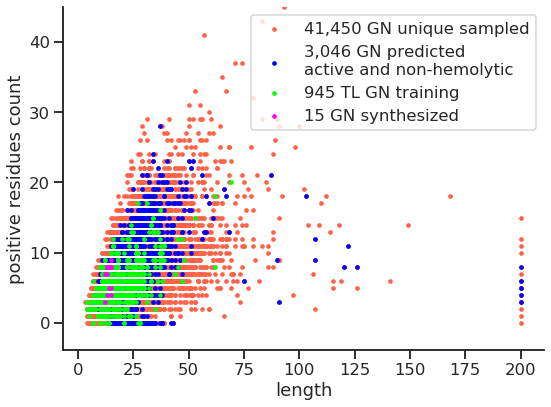

In [180]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_neg_all.plot.scatter(ax = ax,x="length", y="positive", label="41,450 GN unique sampled", c="tomato", s=10, alpha=1, marker="o")
gen_gram_neg.plot.scatter(ax = ax,x="length", y="positive", label="3,046 GN predicted\nactive and non-hemolytic", c="blue", s=10, alpha=1, marker="o")
gram_neg.plot.scatter(ax = ax, x="length", y="positive", label="945 TL GN training", c="lime", s=10, alpha=1, marker="o")
results.query("Set=='GN'").plot.scatter(ax = ax, x="length", y="positive", label="15 GN synthesized", c="magenta", s=10, alpha=1, marker="o")
plt.xlabel("length")
plt.ylabel("positive residues count")
#plt.xlim(-0.01, 30)
plt.ylim(None, 45)
plt.legend(loc="upper right")#, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/length-positive_gn.svg")

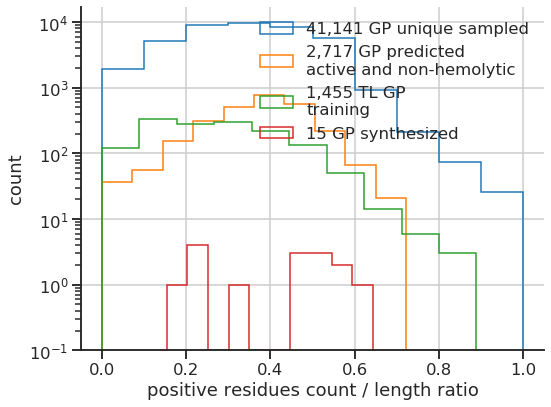

In [245]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_pos_all.pos_len_ratio.hist(ax=ax, label="41,141 GP unique sampled", log=True, histtype="step")
gen_gram_pos.pos_len_ratio.hist(ax=ax, label="2,717 GP predicted\nactive and non-hemolytic", log=True, histtype="step")
gram_pos.pos_len_ratio.hist(ax=ax, label="1,455 TL GP\ntraining", log=True, histtype="step")
results.query("Set=='GP'").pos_len_ratio.hist(ax=ax, label="15 GP synthesized", log=True, histtype="step")
plt.xlabel("positive residues count / length ratio")
plt.ylabel("count")
#plt.xlim(-0.01, 30)
#plt.ylim(None, 45)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ration_gp_hist.svg")

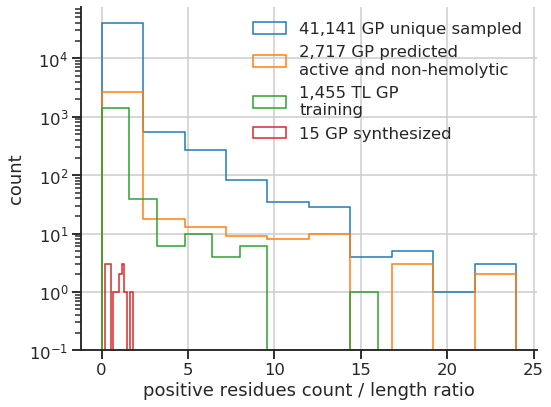

In [247]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_pos_all.pos_hy_ratio.hist(ax=ax, label="41,141 GP unique sampled", log=True, histtype="step")
gen_gram_pos.pos_hy_ratio.hist(ax=ax, label="2,717 GP predicted\nactive and non-hemolytic", log=True, histtype="step")
gram_pos.pos_hy_ratio.hist(ax=ax, label="1,455 TL GP\ntraining", log=True, histtype="step")
results.query("Set=='GP'").pos_hy_ratio.hist(ax=ax, label="15 GP synthesized", log=True, histtype="step")
plt.xlabel("positive residues count / length ratio")
plt.ylabel("count")
#plt.xlim(-0.01, 30)
#plt.ylim(None, 45)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_hy_ration_gp_hist.svg")

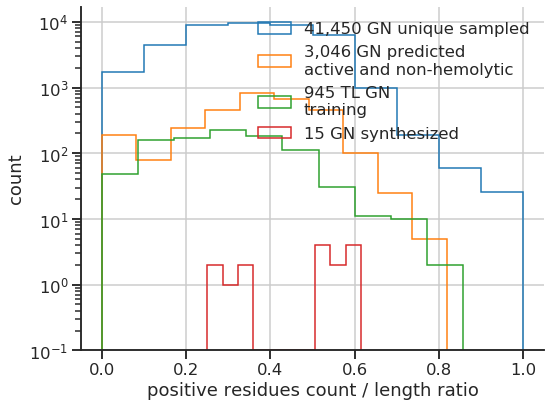

In [246]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_neg_all.pos_len_ratio.hist(ax=ax, label="41,450 GN unique sampled", log=True, histtype="step")
gen_gram_neg.pos_len_ratio.hist(ax=ax, label="3,046 GN predicted\nactive and non-hemolytic", log=True, histtype="step")
gram_neg.pos_len_ratio.hist(ax=ax, label="945 TL GN\ntraining", log=True, histtype="step")
results.query("Set=='GN'").pos_len_ratio.hist(ax=ax, label="15 GN synthesized", log=True, histtype="step")
plt.xlabel("positive residues count / length ratio")
plt.ylabel("count")
#plt.xlim(-0.01, 30)
#plt.ylim(None, 45)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ration_gn_hist.svg")

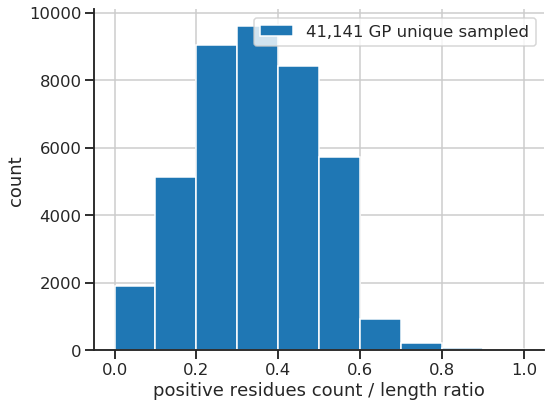

In [232]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")

plt.xlabel("positive residues count / length ratio")
plt.ylabel("count")
#plt.xlim(-0.01, 30)
#plt.ylim(None, 45)
plt.legend(loc="upper right")#, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ration_gp_generated.svg")

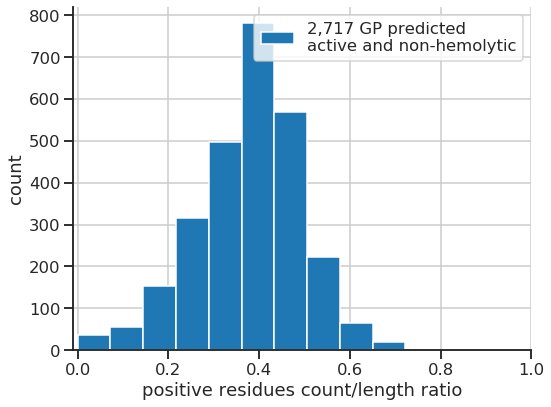

In [264]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_pos.pos_len_ratio.hist(ax=ax, label="2,717 GP predicted\nactive and non-hemolytic", bins=10)
plt.xlabel("positive residues count/length ratio")
plt.ylabel("count")
plt.xlim(-0.01, 1)
#plt.ylim(None, 45)
plt.legend(loc="upper right")#, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ration_gp_generated_and_class_filtered.svg")

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_pos.pos_len_ratio.hist(ax=ax, label="2,717 GP predicted\nactive and non-hemolytic")
plt.xlabel("positive residues count / length ratio")
plt.ylabel("count")
#plt.xlim(-0.01, 30)
#plt.ylim(None, 45)
plt.legend(loc="upper right")#, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ration_gp_generated_and_class_filtered.svg")

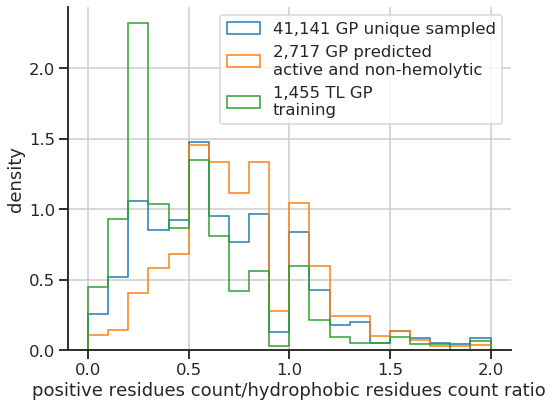

In [325]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_pos_all.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax, label="41,141 GP unique sampled", bins=20, density=True, histtype="step")#, stacked=True)
gen_gram_pos.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax, label="2,717 GP predicted\nactive and non-hemolytic", bins=20, density=True, histtype="step")#, stacked=True)
gram_pos.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax, label="1,455 TL GP\ntraining", bins=20, density=True, histtype="step")#, stacked=True)
#results.query("Set=='GP' and pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax, label="15 Synthesized GP", bins=20, stacked=True)
plt.xlabel("positive residues count/hydrophobic residues count ratio")
plt.ylabel("density")
#plt.xlim(-0.01, 2)
#plt.ylim(None, 45)
plt.legend(loc="upper right")#, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_hy_ratio_gp_all_n.svg")

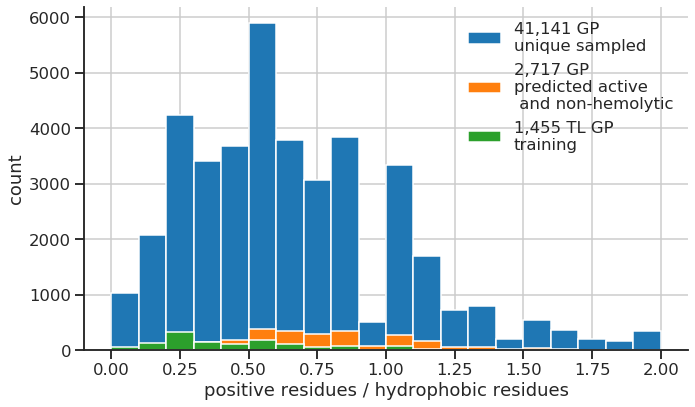

In [362]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_pos_all.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax, label="41,141 GP\nunique sampled", bins=20)#, stacked=True)
gen_gram_pos.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax, label="2,717 GP\npredicted active\n and non-hemolytic", bins=20)#, stacked=True)
gram_pos.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax, label="1,455 TL GP\ntraining", bins=20)#, stacked=True)
#results.query("Set=='GP' and pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax, label="15 Synthesized GP", bins=20, stacked=True)
plt.xlabel("positive residues / hydrophobic residues")
plt.ylabel("count")
#plt.xlim(-0.01, 2)
#plt.ylim(None, 45)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_hy_ratio_gp_all.svg")

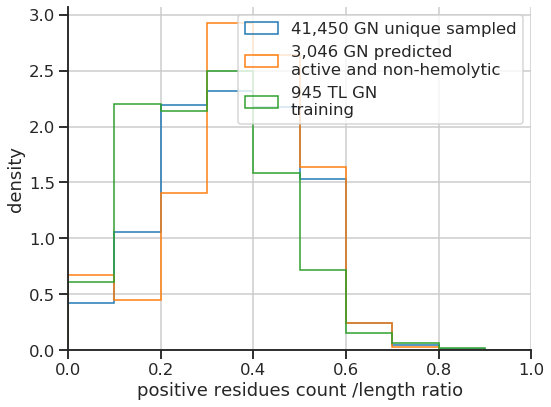

In [326]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")

gen_gram_neg_all.query("pos_len_ratio<=1").pos_len_ratio.hist(label="41,450 GN unique sampled", bins=10, density=True, histtype="step")
gen_gram_neg.query("pos_len_ratio<=1").pos_len_ratio.hist(ax = ax, label="3,046 GN predicted\nactive and non-hemolytic",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], density=True, histtype="step")
gram_neg.query("pos_len_ratio<=1").pos_len_ratio.hist(ax=ax,label="945 TL GN\ntraining",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], density=True, histtype="step")

#results.query("Set=='GN'").pos_len_ratio.hist(ax = ax, label="15 GN synthesized", color="magenta", density=True)

plt.xlabel("positive residues count /length ratio")
plt.ylabel("density")
plt.xlim(0, 1)
#plt.ylim(None, 45)
plt.legend(loc="upper right")#, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ratio_gn_all_n.svg")

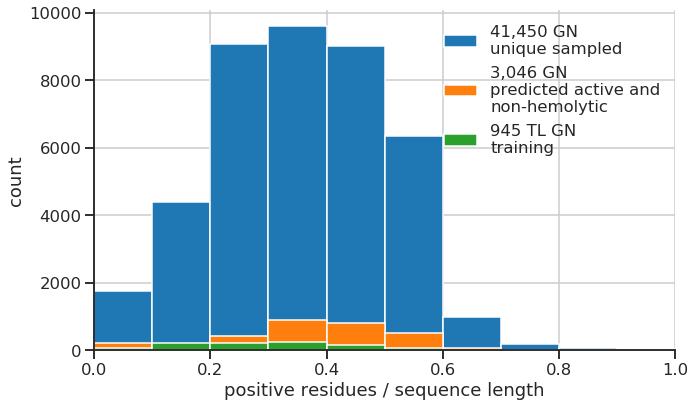

In [360]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style(style="ticks")
sns.set_context("talk")

gen_gram_neg_all.query("pos_len_ratio<=1").pos_len_ratio.hist(label="41,450 GN\nunique sampled", bins=10)
gen_gram_neg.query("pos_len_ratio<=1").pos_len_ratio.hist(ax = ax, label="3,046 GN\npredicted active and\nnon-hemolytic",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
gram_neg.query("pos_len_ratio<=1").pos_len_ratio.hist(ax=ax,label="945 TL GN\ntraining",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

#results.query("Set=='GN'").pos_len_ratio.hist(ax = ax, label="15 GN synthesized", color="magenta", density=True)

plt.xlabel("positive residues / sequence length")
plt.ylabel("count")
plt.xlim(0, 1)
#plt.ylim(None, 45)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ratio_gn_all.svg")

In [319]:
len(gen_gram_pos)

2717

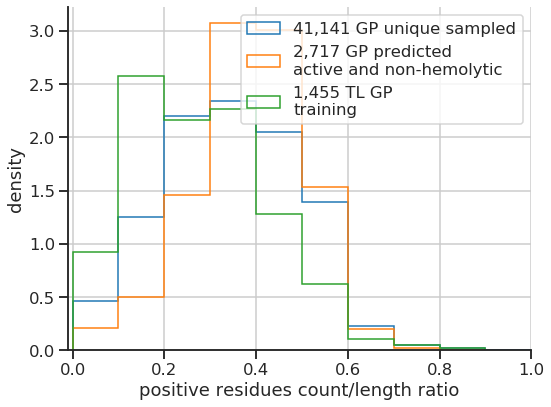

In [327]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")

gen_gram_pos_all.pos_len_ratio.hist(label="41,141 GP unique sampled", density=True, histtype="step",bins=10)
gen_gram_pos.pos_len_ratio.hist(ax = ax, label="2,717 GP predicted\nactive and non-hemolytic", density=True, histtype="step",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
gram_pos.pos_len_ratio.hist(ax=ax,label="1,455 TL GP\ntraining",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], density=True, histtype="step")

#results.query("Set=='GN'").pos_len_ratio.hist(ax = ax, label="15 GN synthesized", color="magenta", density=True)

plt.xlabel("positive residues count/length ratio")
plt.ylabel("density")
plt.xlim(-0.01, 1)
#plt.ylim(None, 45)
plt.legend(loc="upper right")#, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ratio_gp_all_n.svg")

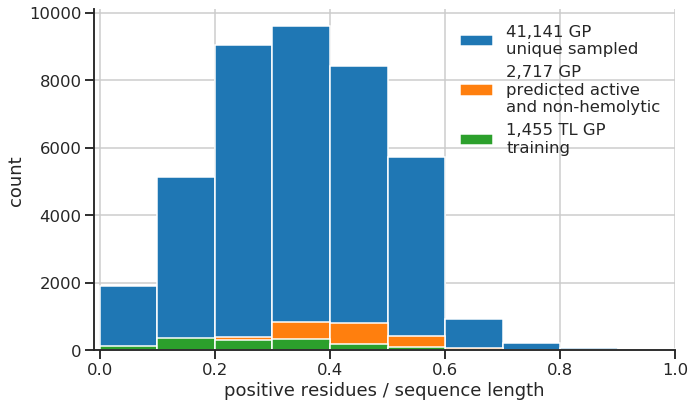

In [359]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style(style="ticks")
sns.set_context("talk")

gen_gram_pos_all.pos_len_ratio.hist(label="41,141 GP\nunique sampled",bins=10)
gen_gram_pos.pos_len_ratio.hist(ax = ax, label="2,717 GP\npredicted active\nand non-hemolytic",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
gram_pos.pos_len_ratio.hist(ax=ax,label="1,455 TL GP\ntraining",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

#results.query("Set=='GN'").pos_len_ratio.hist(ax = ax, label="15 GN synthesized", color="magenta", density=True)

plt.xlabel("positive residues / sequence length")
plt.ylabel("count")
plt.xlim(-0.01, 1)
#plt.ylim(None, 45)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_len_ratio_gp_all.svg")

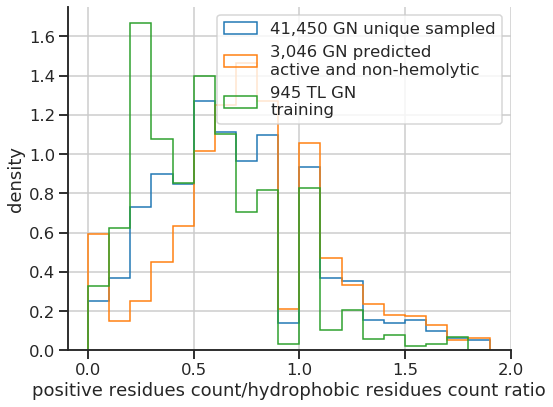

In [329]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")

gen_gram_neg_all.query("pos_hy_ratio<=2").pos_hy_ratio.hist(label="41,450 GN unique sampled", density=True, histtype="step", bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])
gen_gram_neg.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax = ax, label="3,046 GN predicted\nactive and non-hemolytic", density=True, histtype="step",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])
gram_neg.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax,label="945 TL GN\ntraining",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9], density=True, histtype="step")

#results.query("Set=='GN'").pos_len_ratio.hist(ax = ax, label="15 GN synthesized", color="magenta", density=True)

plt.xlabel("positive residues count/hydrophobic residues count ratio")
plt.ylabel("density")
#plt.xlim(-0.01, 30)
plt.xlim(None, 2)
plt.legend(loc="upper right")#, frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_hy_ratio_gn_all_n.svg")

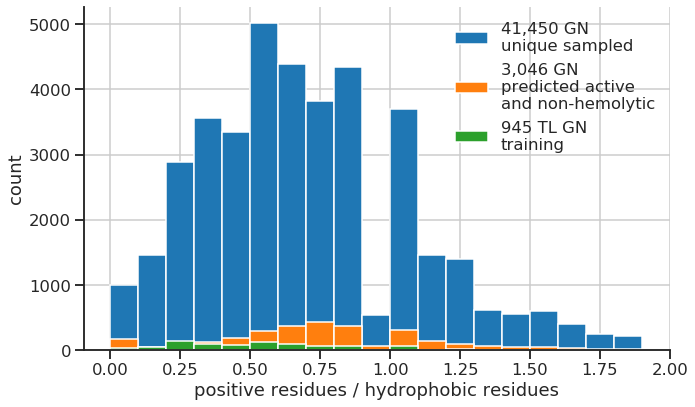

In [358]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.set_style(style="ticks")
sns.set_context("talk")

gen_gram_neg_all.query("pos_hy_ratio<=2").pos_hy_ratio.hist(label="41,450 GN\nunique sampled", bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])
gen_gram_neg.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax = ax, label="3,046 GN\npredicted active\nand non-hemolytic",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])
gram_neg.query("pos_hy_ratio<=2").pos_hy_ratio.hist(ax=ax,label="945 TL GN\ntraining",bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9])

#results.query("Set=='GN'").pos_len_ratio.hist(ax = ax, label="15 GN synthesized", color="magenta", density=True)

plt.xlabel("positive residues / hydrophobic residues")
plt.ylabel("count")
#plt.xlim(-0.01, 30)
plt.xlim(None, 2)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/pos_hy_ratio_gn_all.svg")

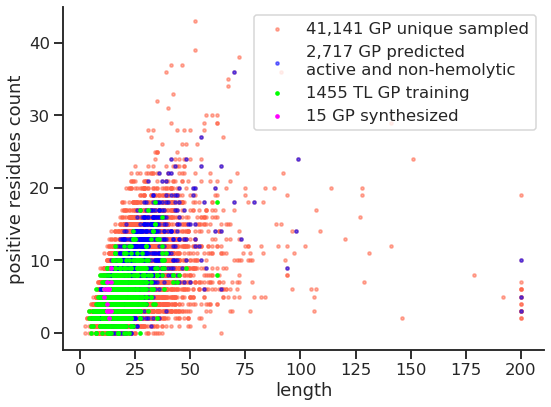

In [231]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style(style="ticks")
sns.set_context("talk")
gen_gram_pos_all.plot.scatter(ax = ax,x="length", y="positive", label="41,141 GP unique sampled", c="tomato", s=10, alpha=0.5, marker="o")
gen_gram_pos.plot.scatter(ax = ax,x="length", y="positive", label="2,717 GP predicted\nactive and non-hemolytic", c="blue", s=10, alpha=0.5, marker="o")
gram_pos.plot.scatter(ax = ax, x="length", y="positive", label="1455 TL GP training", c="lime", s=10, alpha=1, marker="o")
results.query("Set=='GP'").plot.scatter(ax = ax, x="length", y="positive", label="15 GP synthesized", c="magenta", s=10, alpha=1, marker="o")
plt.xlabel("length")
plt.ylabel("positive residues count")
#plt.xlim(-0.01, 30)
plt.ylim(None, 45)
#plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/length-positive_gp.svg")

In [75]:
gram_neg["setplot"] = "generated GN"
gram_pos["setplot"] = "generated GP"
forplot = pd.concat([gram_neg, gram_pos])
forplot["presence\nD-AA"] = forplot["D_AA"]

/home/alice/miniconda3/envs/aipep/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/alice/miniconda3/envs/aipep/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Plot NN

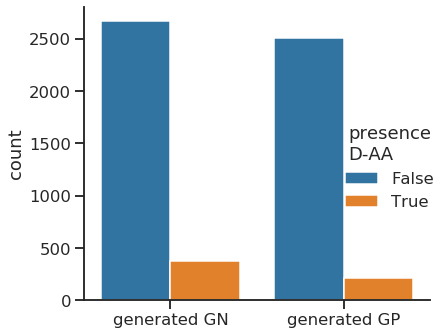

In [76]:
import seaborn as sns

sns.set_style(style="ticks")
sns.set_context("talk")

sns.catplot(x="setplot", hue="presence\nD-AA", kind="count", data=forplot)
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.savefig("plots/daa.svg")

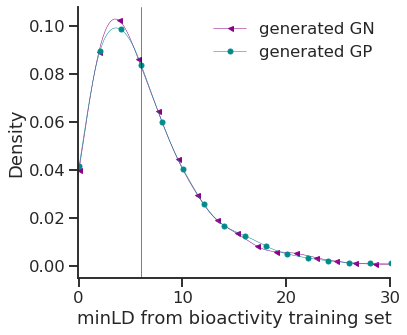

In [7]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.set_style(style="ticks")
sns.set_context("talk")

gram_neg.dist_Training_act.plot.kde(label="generated GN", c="darkmagenta", linewidth=0.5, marker = "<", markersize=5, markevery=10)
gram_pos.dist_Training_act.plot.kde(label="generated GP", c="darkcyan", linewidth=0.5, marker = "o", markersize=5, markevery=10)

plt.axvline(x=6, c="black", linestyle="-", linewidth=1, alpha=0.5)
#plt.axvline(x=7, c="black", linestyle="-", linewidth=1, alpha=0.5)
plt.xlabel("minLD from bioactivity training set")
plt.xlim(-0.01, 30)
#plt.ylim(None, 0.14)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/minLD-from-Bioactivity-Training-Set.svg")

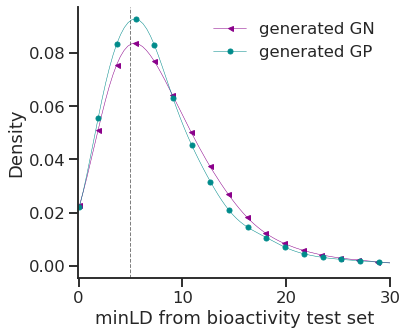

In [8]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.set_style(style="ticks")
sns.set_context("talk")

gram_neg.dist_Test_act.plot.kde(label="generated GN", c="darkmagenta", linewidth=0.5, marker = "<", markersize=5, markevery=5)
gram_pos.dist_Test_act.plot.kde(label="generated GP", c="darkcyan", linewidth=0.5, marker = "o", markersize=5, markevery=5)

plt.axvline(x=5, c="black", linestyle="--", linewidth=1, alpha=0.5)

plt.xlabel("minLD from bioactivity test set")
plt.xlim(-0.01, 30)

plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/minLD-from-Bioactivity-Test-Set.svg")


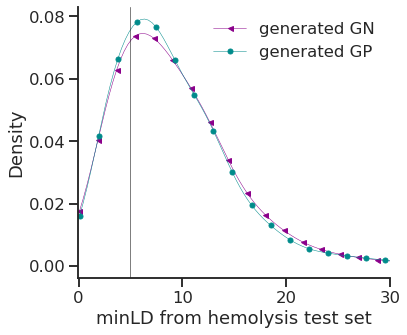

In [9]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.set_style(style="ticks")
sns.set_context("talk")

gram_neg.dist_Test_hem.plot.kde(label="generated GN", c="darkmagenta", linewidth=0.5, marker = "<", markersize=5, markevery=5)
gram_pos.dist_Test_hem.plot.kde(label="generated GP", c="darkcyan", linewidth=0.5, marker = "o", markersize=5, markevery=5)

plt.axvline(x=5, c="black", linestyle="-", linewidth=1, alpha=0.5)

plt.xlabel("minLD from hemolysis test set")
plt.xlim(-0.01, 30)

plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/minLD-from-hemolysis-Test-Set.svg")

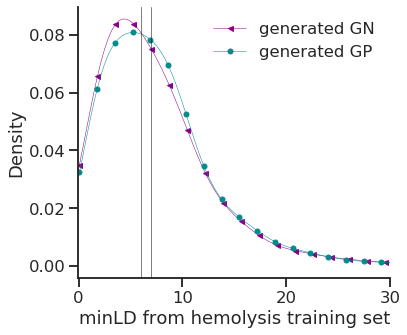

In [10]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.set_style(style="ticks")
sns.set_context("talk")

gram_neg.dist_Training_hem.plot.kde(label="generated GN", c="darkmagenta", linewidth=0.5, marker = "<", markersize=5, markevery=5)
gram_pos.dist_Training_hem.plot.kde(label="generated GP", c="darkcyan", linewidth=0.5, marker = "o", markersize=5, markevery=5)

plt.axvline(x=6, c="black", linestyle="-", linewidth=1, alpha=0.5)
plt.axvline(x=7, c="black", linestyle="-", linewidth=1, alpha=0.5)
plt.xlabel("minLD from hemolysis training set")
plt.xlim(-0.01, 30)

plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/minLD-from-hemolysis-Training-Set.svg")

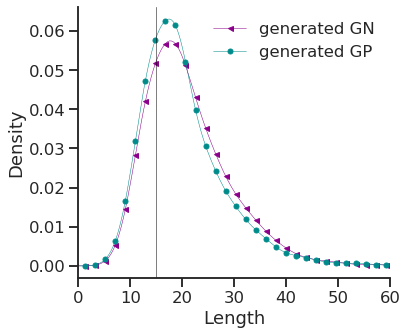

In [11]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.set_style(style="ticks")
sns.set_context("talk")

gram_neg.length.plot.kde(label="generated GN", c="darkmagenta", linewidth=0.5, marker = "<", markersize=5, markevery=5)
gram_pos.length.plot.kde(label="generated GP", c="darkcyan", linewidth=0.5, marker = "o", markersize=5, markevery=5)

plt.axvline(x=15, c="black", linestyle="-", linewidth=1, alpha=0.5)
plt.xlabel("Length")
plt.xlim(0, 60)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/length.svg")

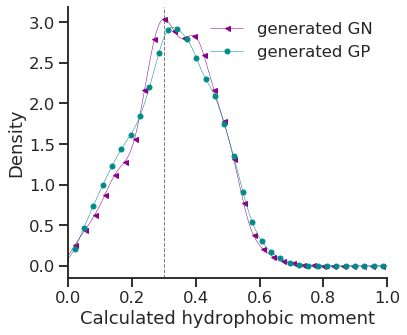

In [12]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.set_style(style="ticks")
sns.set_context("talk")

gram_neg.HydroMoment.plot.kde(label="generated GN", c="darkmagenta", linewidth=0.5, marker = "<", markersize=5, markevery=20)
gram_pos.HydroMoment.plot.kde(label="generated GP", c="darkcyan", linewidth=0.5, marker = "o", markersize=5, markevery=20)

plt.axvline(x=0.3, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("Calculated hydrophobic moment")
plt.xlim(0, 1)
plt.legend(loc="upper right", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/hydromoment.svg")

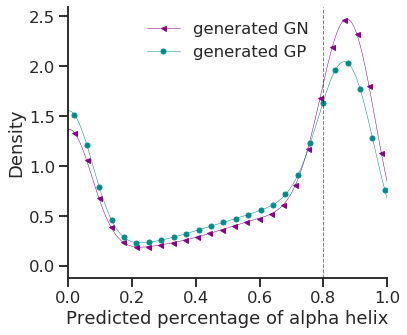

In [13]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.set_style(style="ticks")
sns.set_context("talk")

gram_neg.fraction_PredHelical.plot.kde(label="generated GN", c="darkmagenta", linewidth=0.5, marker = "<", markersize=5, markevery=20)
gram_pos.fraction_PredHelical.plot.kde(label="generated GP", c="darkcyan", linewidth=0.5, marker = "o", markersize=5, markevery=20)

plt.axvline(x=0.8, c="black", linestyle="--", linewidth=1, alpha=0.5)
plt.xlabel("Predicted percentage of alpha helix")
plt.xlim(0, 1)
plt.legend(loc="upper center", frameon=False)
sns.despine()
plt.tight_layout()
plt.savefig("plots/helix.svg")

import seaborn as sns
fig,ax = plt.subplots(figsize=(6,5))
sns.set_style(style="ticks")
print(len(gram_neg), len(gram_pos), len(active), len(inactive))
gram_neg_sub = gram_neg.sample(n=400)
gram_pos_sub = gram_pos.sample(n=400)
active_sub = active.sample(n=400)
inactive_sub = inactive.sample(n=400)


gram_pos_sub.plot.scatter(x="fraction_PredHelical", y="HydroMoment", label="generated GP", c="blue", linewidth=1,ax=ax,s=10, alpha=0.8, marker="o")

plt.axvline(x=0.8, c="black", linestyle="-", linewidth=2, alpha=0.5, ymin=0.375, ymax=1)
plt.axhline(y=0.3, c="black", linestyle="-", linewidth=2, alpha=0.5, xmin=0.8, xmax=1)
plt.axvline(x=1, c="black", linestyle="-", linewidth=2, alpha=0.5, ymin=0.375, ymax=1)
plt.axhline(y=0.8, c="black", linestyle="-", linewidth=2, alpha=0.5, xmin=0.8, xmax=1)
plt.xlabel("Predicted percentage of alpha helix")
plt.ylabel("Calculated\nhydrophobic moment")
plt.xlim(0, 1)
plt.ylim(0, 0.8)
plt.legend(loc="upper left", frameon=False, markerscale=3)
sns.despine()
plt.tight_layout()
plt.savefig("plots/amphi_genN.svg")

In [363]:
results.to_excel("data/results.xlsx")